The Gibson Assembly® Protocol below is obtained from the New England Biolabs (NEB).
DOI: https://dx.doi.org/10.17504/protocols.io.bdddi226

v2.2 corresponds to the version of the process mapping document which can be found here:
https://imperiallondon.sharepoint.com/:w:/s/3rdYearGroupProject-Group1-BM/EUCI6zyDKR5Mu8h0xdkCKxsBZIlt9H7fuby1bR6irCJORQ?e=fNtstf

In [14]:
%reset

In [15]:
from logging import Logger
import os
import logging
import sbol3
import labop
import tyto
import uml
import json
import rdflib as rdfl
from typing import Dict, Tuple
from sbol3 import Document

from labop.execution_engine import ExecutionEngine
from labop_convert.opentrons.opentrons_specialization import OT2Specialization
from labop_convert.markdown.markdown_specialization import MarkdownSpecialization

from IPython.display import Image

# %load_ext autoreload
# %autoreload 2

In [16]:
# set up the document
print('Setting up document')
doc = sbol3.Document()
sbol3.set_namespace('https://bmey3labautomation.com/')

Setting up document


In [17]:
# Import the primitive libraries
print('Importing libraries')
labop.import_library('liquid_handling')
print('... Imported liquid handling')
labop.import_library('plate_handling')
print('... Imported plate handling')
labop.import_library('spectrophotometry')
print('... Imported spectrophotometry')
labop.import_library('sample_arrays')
print('... Imported sample arrays')
labop.import_library('pcr')
print('... Imported pcr')

Importing libraries
... Imported liquid handling
... Imported plate handling
... Imported spectrophotometry
... Imported sample arrays
... Imported pcr


In [18]:
protocol = labop.Protocol('gibson_assembly_v2_0')
protocol.name = "LabOP Opentrons Gibson Assembly Protocol"
doc.add(protocol)

# create the materials to be provisioned
CONT_NS = rdfl.Namespace('https://sift.net/container-ontology/container-ontology#')
OM_NS = rdfl.Namespace('http://www.ontology-of-units-of-measure.org/resource/om-2/')

PREFIX_MAP = json.dumps({"cont": CONT_NS, "om": OM_NS})

In [19]:
# Define reagents
# do we need to define all our reagents? if yes, how do we know which URI for our reagents?
dh2o = sbol3.Component('dH2O', 'https://pubchem.ncbi.nlm.nih.gov/substance/24901740')
dh2o.name = 'Water, sterile-filtered, BioReagent, suitable for cell culture'
doc.add(dh2o)

master_mix = sbol3.Component('master_mix', 'gibsonassemblymastermix')
master_mix.name = 'Gibson Assembly Master Mix'
doc.add(master_mix)

dna_frag1 = sbol3.Component('dna_frag1', 'dnafragments1')
dna_frag1.name = 'DNA Fragment 1'
doc.add(dna_frag1)

dna_frag2 = sbol3.Component('dna_frag2', 'dnafragments2')
dna_frag2.name = 'DNA Fragment 2'
doc.add(dna_frag2)

In [20]:
# Define labware
spec_tiprack = labop.ContainerSpec('tiprack',
                                   queryString='cont:Opentrons96TipRack10uL', # didn't have 20uL tiprack
                                   prefixMap=PREFIX_MAP)
spec_reagent_plate = labop.ContainerSpec('reagent_plate',
                                    name='Well plate for reagents',
                                    queryString='cont:NEST96WellPlate', # NEST 96 deep well plate
                                    prefixMap=PREFIX_MAP)
spec_destination_plate = labop.ContainerSpec('destination_plate',
                                        name='Destination plate',
                                        queryString='cont:BioRad96WellPCRPlate', # NEST 96 PCR
                                        prefixMap=PREFIX_MAP)
p20 = sbol3.Agent('p20_single_gen2',
                  name='P20 Single GEN2')
thermocycler = sbol3.Agent('thermocycler_module',
                           name = 'Thermocycler Module')
doc.add(spec_tiprack)
doc.add(spec_reagent_plate)
doc.add(spec_destination_plate)
doc.add(p20)
doc.add(thermocycler)

tiprack = protocol.primitive_step('EmptyContainer',
                                  specification=spec_tiprack)
reagent_plate = protocol.primitive_step('EmptyContainer',
                                        specification=spec_reagent_plate)
destination_plate = protocol.primitive_step('EmptyContainer',
                                            specification=spec_destination_plate)

In [21]:
# Load OT2 robot with labware
left_pipette = protocol.primitive_step('ConfigureRobot', 
                                       instrument=p20,
                                       mount='left')
thermocycler_module = protocol.primitive_step('ConfigureRobot',
                                              instrument=thermocycler,
                                              mount='7')
tiprack = protocol.primitive_step('LoadRackOnInstrument',
                                  rack=spec_tiprack,
                                  coordinates='1')
load_reagent_plate = protocol.primitive_step('LoadRackOnInstrument',
                                             rack=spec_reagent_plate,
                                             coordinates='4')
load_destination_plate = protocol.primitive_step('LoadContainerOnInstrument',
                                                 specification=spec_destination_plate,
                                                 instrument=thermocycler,
                                                 slots='A1:H12') # 96 wells

In [22]:
# Set up target samples
assembly_reaction = protocol.primitive_step('PlateCoordinates',
                                            source=load_destination_plate.output_pin('samples'),
                                            coordinates='A1:H1')
negative_control = protocol.primitive_step('PlateCoordinates',
                                           source=load_destination_plate.output_pin('samples'),
                                           coordinates='A2:H2')

In [23]:
# Set up reagents - assuming reagents are loaded onto reagent plate manually
master_mix_well = protocol.primitive_step('PlateCoordinates',
                                          source=reagent_plate.output_pin('samples'),
                                          coordinates='A1')
dh2o_well = protocol.primitive_step('PlateCoordinates',
                                    source=reagent_plate.output_pin('samples'),
                                    coordinates='A2')
dna_frag1_well = protocol.primitive_step('PlateCoordinates',
                                         source=reagent_plate.output_pin('samples'),
                                         coordinates='A3')
dna_frag2_well = protocol.primitive_step('PlateCoordinates',
                                         source=reagent_plate.output_pin('samples'),
                                         coordinates='A4')

In [24]:
# Protocol
# does the 'Transfer' primitive step automatically change tip?

hold = protocol.primitive_step('Hold',
                               location=thermocycler,
                               temperature=sbol3.Measure(4.0,tyto.OM.degree_Celsius))
hold.name = '1. Set thermocycler to hold at 4 degrees Celsius while setting up assembly reaction and negative control'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '2. Add deionized H2O for assembly reaction (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(6,tyto.OM.microliter))
transfer.name = '2. Add deionized H2O for assembly reaction (second transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '3. Add deionized H2O for negative control (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(6,tyto.OM.microliter))
transfer.name = '3. Add deionized H2O for negative control (second transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=master_mix_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '4. Add Gibson Assembly Master Mix for assembly reaction (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=master_mix_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '4. Add Gibson Assembly Master Mix for assembly reaction (second transfer)'


transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '5. Add deionized H2O instead of Gibson Assembly Master Mix for negative control (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '5. Add deionized H2O instead of Gibson Assembly Master Mix for negative control (second transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag1_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '6. Add DNA fragment 1 for assembly reaction'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag1_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '7. Add DNA fragment 1 for negative control'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag2_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '8. Add DNA fragment 2 for assembly reaction'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag2_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '9. Add DNA fragment 2 for negative control'

# how to accommodate mixing 20uL (half of total volume) if pipette tip max is 10uL
mix = protocol.primitive_step('PipetteMix',
                              samples=assembly_reaction.output_pin('samples'),
                              amount=sbol3.Measure(10,tyto.OM.microliter),
                              cycleCount=5)
mix.name = 'Mix 5 times'

incubate = protocol.primitive_step('Incubate',
                                   location=thermocycler,
                                   duration=sbol3.Measure(15,tyto.OM.minute),
                                   temperature=sbol3.Measure(50,tyto.OM.degree_Celsius))
incubate.name = 'Incubate at 50 degrees Celsius for 15 minutes'

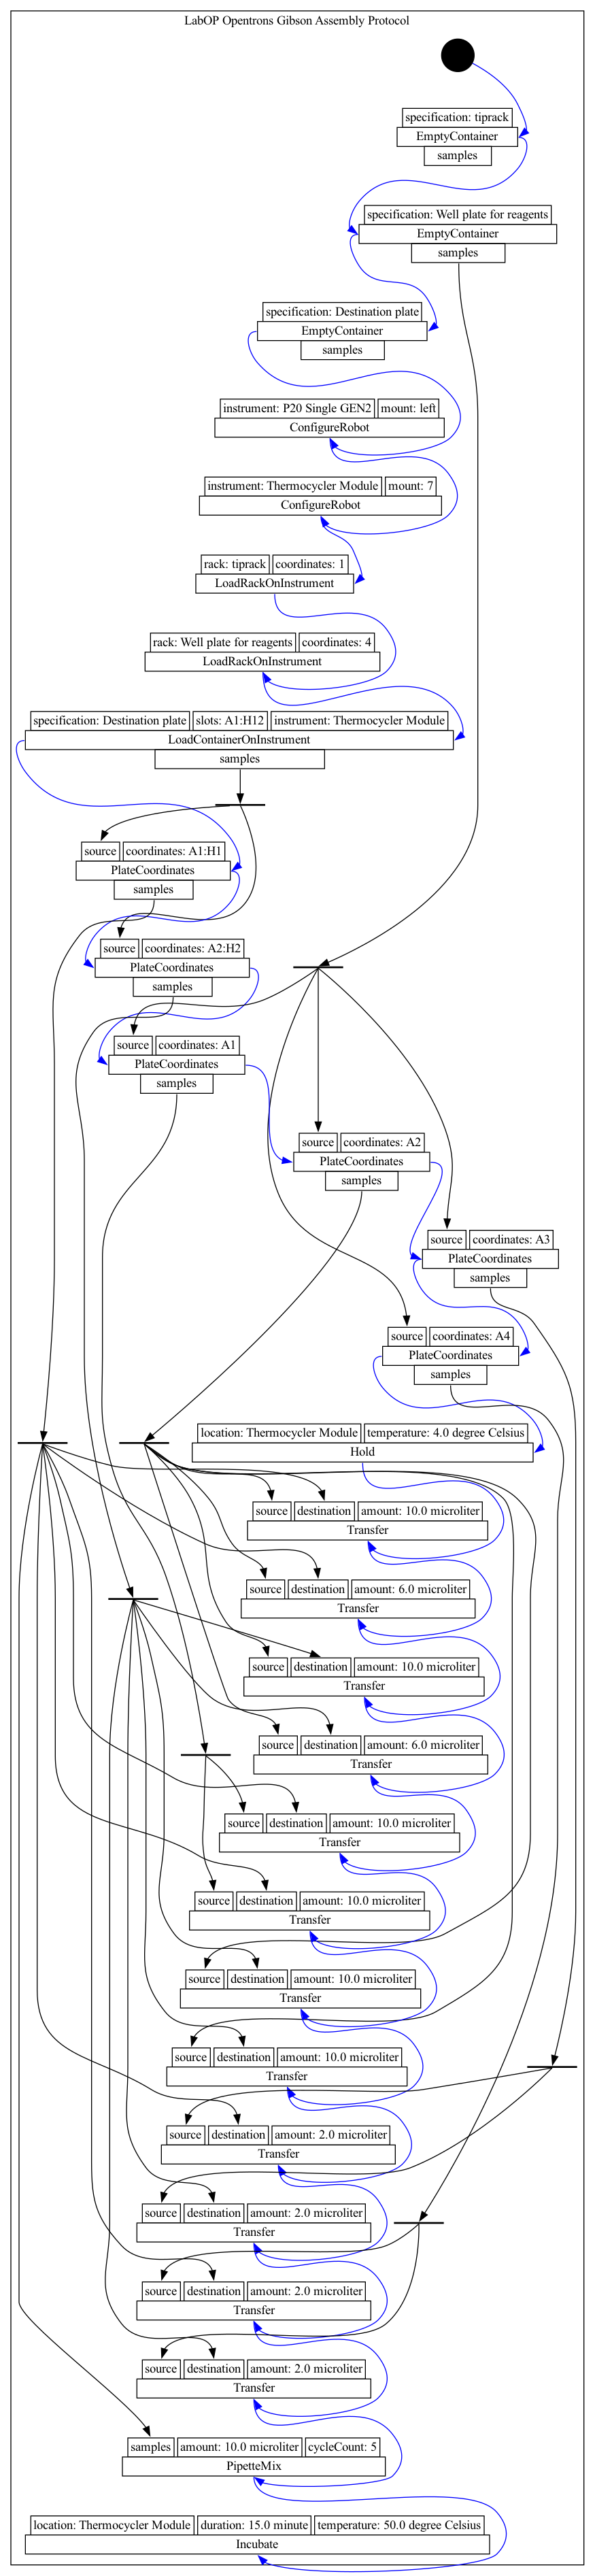

In [25]:
out_dir = os.path.join(os.path.abspath(""), "test")
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

protocol.to_dot().render(filename=os.path.join(out_dir,protocol.display_name), format='png')

Image(os.path.join(out_dir, protocol.display_name+".png"))

In [26]:
filename = 'ot2_gibson_assembly_labop'
agent = sbol3.Agent('ot2_machine', name='OT2 Machine')
ee = ExecutionEngine(specializations=[OT2Specialization(filename)])
parameter_values = []
execution = ee.execute(protocol, agent, id='test_execution')

LookupError: No matching term found for cont:Opentrons96TipRack10uL